# A model for chlamydia surveillance data

We propose a three-compartment model of chlamydia infection, testing and screening as illustrated below. Susceptible individuals (S) become infected with a constant incidence, and move to either the asymptomatic-infected (A) or symptomatic-infected (I) pool. Asymptomatic-infected individuals may leave A and return to S by spontaneous clearance of their infection or by detection and treatment under a screening programme. Symptomatic individuals too may clear their infection spontaneously or be screened, but will also seek treatment at a rate which is typically much higher than the rates of spontaneous clearance or screening. 

<img src="figures/3_comp.png", width=500>

This dynamic model has a steady-state solution which depends on the transition rates $\alpha_{SA}$, $\alpha_{AS}$, $\alpha_{SI}$ and $\alpha_{IS}$:

In [1]:
import sympy as sym
from sympy import *
A, S, I = symbols("A S I")
alpha_SA, alpha_AS, alpha_SI, alpha_IS  = symbols("alpha_SA alpha_AS alpha_SI alpha_IS")

model_dyn = [
    alpha_SA*S - alpha_AS*A,
    alpha_AS*A + alpha_IS*I - (alpha_SA + alpha_SI)*S,
    alpha_SI*S - alpha_IS*I,
    A + S + I - 1 # this equation sets the total population size to 1
    ]

# steady-state solution
sol_dyn = solve(model_dyn, A, S, I)

# functions for calculating the proportion of the population in each compartment at 
# steady state, given transition rates between compartments
dyn_fun = lambdify((alpha_SA, alpha_AS, alpha_SI, alpha_IS), sol_dyn[A] + sol_dyn[I])
S_fun = lambdify((alpha_SA, alpha_AS, alpha_SI, alpha_IS), sol_dyn[S])
A_fun = lambdify((alpha_SA, alpha_AS, alpha_SI, alpha_IS), sol_dyn[A])
I_fun = lambdify((alpha_SA, alpha_AS, alpha_SI, alpha_IS), sol_dyn[I])

sol_dyn

{S: alpha_AS*alpha_IS/(alpha_AS*alpha_SI + alpha_IS*(alpha_AS + alpha_SA)),
 A: alpha_IS*alpha_SA/(alpha_AS*alpha_SI + alpha_IS*(alpha_AS + alpha_SA)),
 I: alpha_AS*alpha_SI/(alpha_AS*alpha_SI + alpha_IS*(alpha_AS + alpha_SA))}

The transition rates are functions of parameters describing behaviour and the natural history of infection:

$$
\begin{eqnarray}
\alpha_{SA} && = && \mbox{incidence} \times (1 - p_{symptomatic}) \\
\alpha_{AS} && = && \mbox{rate of spontaneous clearance} + \mbox{rate of screening} \times p_{true positive} \\
\alpha_{SI} && = && \mbox{incidence} \times p_{symptomatic} \\
\alpha_{IS} && = && \mbox{rate of spontaneous clearance} + \mbox{rate of screening} \times p_{true positive} + \mbox{rate of symptomatic testing} \times p_{true positive}
\end{eqnarray}
$$

Assuming all tests conducted are included in the surveillance data, the number of tests reported per unit time will be:

$$
\mbox{rate of testing} = \mbox{rate of screening} + I \times \mbox{rate of symptomatic testing}
$$

And the number of diagnoses per unit time will be:

$$
\mbox{rate of new diagnoses} = (A+I) \times (\mbox{rate of screening} \times p_{true positive}) + 
(S \times \mbox{rate of screening} \times p_{false positive}) +
(I \times \mbox{rate of symptomatic testing} \times p_{truepositive})
$$

Let's assume that:

* 87.5% of incident infections are asymptomatic.
* Infections (whether symptomatic or not) clear spontaneously or through background antibiotic use at a rate 4.71 per year.
* Symptomatic cases seek and obtain testing and treatment at a rate 15.3 per year.
* The true positive rate for the diagnostic test is 0.971.
* The false positive rate for the diagnostic test is 0.00314.

In [3]:
p_asymp = 0.875
sc = 4.71
att_symp = 15.3
p_true_pos = 0.971
p_false_pos = 0.00314

It is then possible to calculate the steady-state proportion of the population in each compartment given the rate of screening and incidence, and from these proportions to calculate the total prevalence, and the rates of new tests and diagnoses.

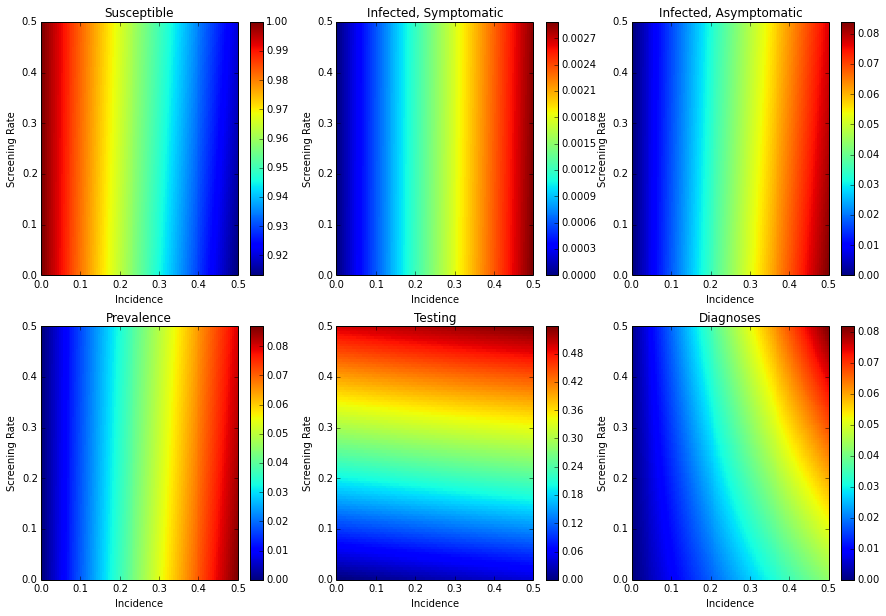

In [4]:
%matplotlib inline
from numpy import *
import matplotlib.pyplot as plt

inc = linspace(0, 0.5, 101) # incidence
scr = linspace(0, 0.5, 101) # screening
inc,scr = meshgrid(inc, scr)

# proportion of population in each compartment
ZS = S_fun(inc*p_asymp, sc + scr*p_true_pos, inc*(1-p_asymp), sc + scr*p_true_pos + att_symp*p_true_pos)
ZA = A_fun(inc*p_asymp, sc + scr*p_true_pos, inc*(1-p_asymp), sc + scr*p_true_pos + att_symp*p_true_pos)
ZI = I_fun(inc*p_asymp, sc + scr*p_true_pos, inc*(1-p_asymp), sc + scr*p_true_pos + att_symp*p_true_pos)

Zprev = 1 - ZS
Ztest = scr + ZI*att_symp
Zdiag = (ZA+ZI)*scr*p_true_pos + ZS*scr*p_false_pos + ZI*att_symp*p_true_pos
        
fig = plt.figure(figsize = (15,10))

ax1 = fig.add_subplot(231)
p = ax1.pcolor(inc,scr, ZS)
cb = fig.colorbar(p, ax=ax1)
ax1.set_xlabel('Incidence')
ax1.set_ylabel('Screening Rate')
ax1.set_title('Susceptible');
ax1.set_ylim(0, 0.5)
ax1.set_xlim(0, 0.5)

ax2 = fig.add_subplot(232)
p = ax2.pcolor(inc,scr, ZI)
cb = fig.colorbar(p, ax=ax2)
ax2.set_xlabel('Incidence')
ax2.set_ylabel('Screening Rate')
ax2.set_title('Infected, Symptomatic');
ax2.set_ylim(0, 0.5)
ax2.set_xlim(0, 0.5)

ax3 = fig.add_subplot(233)
p = ax3.pcolor(inc,scr, ZA)
cb = fig.colorbar(p, ax=ax3)
ax3.set_xlabel('Incidence')
ax3.set_ylabel('Screening Rate')
ax3.set_title('Infected, Asymptomatic');
ax3.set_ylim(0, 0.5)
ax3.set_xlim(0, 0.5)

ax4 = fig.add_subplot(234)
p = ax4.pcolor(inc,scr, Zprev)
cb = fig.colorbar(p, ax=ax4)
ax4.set_xlabel('Incidence')
ax4.set_ylabel('Screening Rate')
ax4.set_title('Prevalence');
ax4.set_ylim(0, 0.5)
ax4.set_xlim(0, 0.5)

ax5 = fig.add_subplot(235)
p = ax5.pcolor(inc,scr, Ztest)
cb = fig.colorbar(p, ax=ax5)
ax5.set_xlabel('Incidence')
ax5.set_ylabel('Screening Rate')
ax5.set_title('Testing');
ax5.set_ylim(0, 0.5)
ax5.set_xlim(0, 0.5)

ax6 = fig.add_subplot(236)
p = ax6.pcolor(inc,scr, Zdiag)
cb = fig.colorbar(p, ax=ax6)
ax6.set_xlabel('Incidence')
ax6.set_ylabel('Screening Rate')
ax6.set_title('Diagnoses');
ax6.set_ylim(0, 0.5)
ax6.set_xlim(0, 0.5)

plt.show()   

From the figures, it is clear that a particular pair of observed testing and diagnosis rates corresponds to a single point in the (incidence, screening rate) plane, which in turn corresponds to a particular prevalence. Note, however, that this mapping depends on the parameter values which have been assumed.

## Partner Notification

To investigate the effect of partner notification, we assume that for every treated case an additional $x$ infected partners are tested and treated. The value of $x$ depends on a combination of the number of partners tested and the proportion of these who are infected. Any notification of symptomatic partners is regarded as negligible here because symptomatic cases will seek treatment at a much faster rate than they are notified by partners. We introduce the terms $A \times PNA$ and $I \times PNI$, representing the per-person rates of treatment of asymptomatic partners as a result of notification by asymptomatic and symptomatic cases, respectively:

$$
\begin{eqnarray}
A \times PNA && = && x . \mbox{rate of screening} . p_{true positive} \\
I \times PNI && = && x . (\mbox{rate of screening} + \mbox{rate of symptomatic testing}) . p_{true positive}
\end{eqnarray}
$$


In [5]:
PNA, PNI = symbols("PNA PNI") # contributions to partner notification 

# model for dynamics
model_pn = [
    alpha_SA*S - alpha_AS*A - (PNA*A + PNI*I)*A,
    alpha_AS*A + alpha_IS*I - (alpha_SA + alpha_SI)*S + (PNA*A + PNI*I)*A,
    alpha_SI*S - alpha_IS*I,
    A + S + I - 1
    ]

# solution
sol_pn = solve(model_pn, A, S, I)

# function to calculate the proportion susceptible in the partner notification model
S_pn = lambdify((alpha_SA, alpha_AS, alpha_SI, alpha_IS, PNA, PNI), sol_pn[0][1]) # the other solution gives negative prevalence

We can now investigate the effect on prevalence of increasing screening and partner notification rate ($x$). Two models for incidence are compared. In the first, incidence is fixed at 0.15 per person per year. In the second, it is 1.5 times the prevalence: that is, each infected person causes 1.5 new infections per year.

NameError: name 'fsolve' is not defined

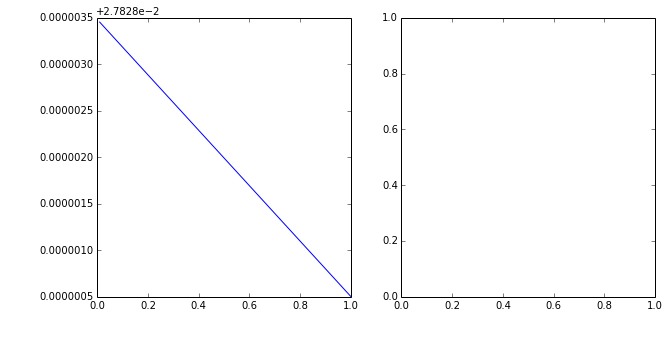

In [6]:
import matplotlib.text as txt

alpha = 1.5 # constant of proportionality between prevalence and incidence
scr = 0.02*(1.+array(range(5))) # vary screening rate
x = 0.01*(1.+array(range(100))) # vary x
ZS = zeros_like(x) # set up array for (1 - prevalence)

fig = plt.figure(figsize=(10,5))
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)

for i in xrange(5):
    for j in xrange(100):
        inc = 0.15
        ZS[j] = S_pn(
                inc*p_asymp, 
                sc + scr[i]*p_true_pos, 
                inc*(1-p_asymp), 
                sc + scr[i]*p_true_pos + att_symp*p_true_pos, 
                x[j]*scr[i]*p_true_pos, 
                (x[j]*scr[i]+att_symp)*p_true_pos
                )
    ax1.plot(x,1-ZS)
    ax1.annotate(' '.join(['', str(scr[i])]), [0.1*(i+1), 1-ZS[10+10*i]-0.0005])
    for j in xrange(100):
        inc = fsolve(
            lambda tmp: S_pn(
                tmp*p_asymp, 
                sc + scr[i]*p_true_pos, 
                tmp*(1-p_asymp), 
                sc + scr[i]*p_true_pos + att_symp*p_true_pos, 
                x[j]*scr[i]*p_true_pos, 
                (x[j]*scr[i]+att_symp)*p_true_pos
                ) - 1 + (tmp/alpha),
            2
            )
        ZS[j] = S_pn(
                inc*p_asymp, 
                sc + scr[i]*p_true_pos, 
                inc*(1-p_asymp), 
                sc + scr[i]*p_true_pos + att_symp*p_true_pos, 
                x[j]*scr[i]*p_true_pos, 
                (x[j]*scr[i]+att_symp)*p_true_pos
                )
    ax2.plot(x,1-ZS)
    ax2.annotate(' '.join(['', str(scr[i])]), [0.1*(i+1), 1-ZS[10+10*i]-0.0005])
    
ant11 = ax1.annotate('', xy=(0.4,0.105), xytext=(0.9, 0.095), arrowprops=dict(arrowstyle='<-'))
ant12 = ax1.annotate(
   'Increasing\nscreening\nrate', 
    xy=(0.7, 0.1), 
    xytext=(0.7, 0.105), 
    horizontalalignment='left', 
    verticalalignment='top')

ant21 = ax2.annotate('', xy=(0.3,0.125), xytext=(0.7, 0.075), arrowprops=dict(arrowstyle='<-'))
ant22 = ax2.annotate(
   'Increasing\nscreening\nrate', 
    xy=(0.6, 0.105), 
    xytext=(0.6, 0.105), 
    horizontalalignment='left', 
    verticalalignment='top')

ax1.set_ylabel('Prevalence')
ax1.set_xlabel('Diagnosed partners, per case found via screening')
ax2.set_xlabel('Diagnosed partners, per case found via screening')

ax1.set_title('Incidence = 0.15')
ax2.set_title('Incidence = 1.5 x prevalence')
ax1.set_ylim([0.07,0.13])
ax2.set_ylim([0.07,0.13])

Prevalence can be lowered by increasing either the screening rate or the number of partners diagnosed through notification. Both measures are more effective when incidence is proportional to prevalence because in addition to curing cases more quickly, the interventions avert new infections.